In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/MyDrive/Axial"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 10000)

Found 5154 files belonging to 3 classes.


In [3]:
class_names = data.class_names
print(class_names)

['AD', 'CI', 'CN']


In [4]:
label_map = {m : n for m, n in zip(np.arange(len(class_names)), class_names)}
print(label_map)

{0: 'AD', 1: 'CI', 2: 'CN'}


In [5]:
for images, labels in data:
    X = images.numpy().astype("uint8")
    y = labels.numpy().astype("uint8")

print(X.shape, y.shape)

(5154, 128, 128, 3) (5154,)


In [6]:
X_gray = np.zeros(shape = (*X.shape[:-1], 1))

for idx, img in enumerate(X):
    X_gray[idx] = tf.image.rgb_to_grayscale(img)

X = X_gray.copy()
print(X_gray.shape)

(5154, 128, 128, 1)


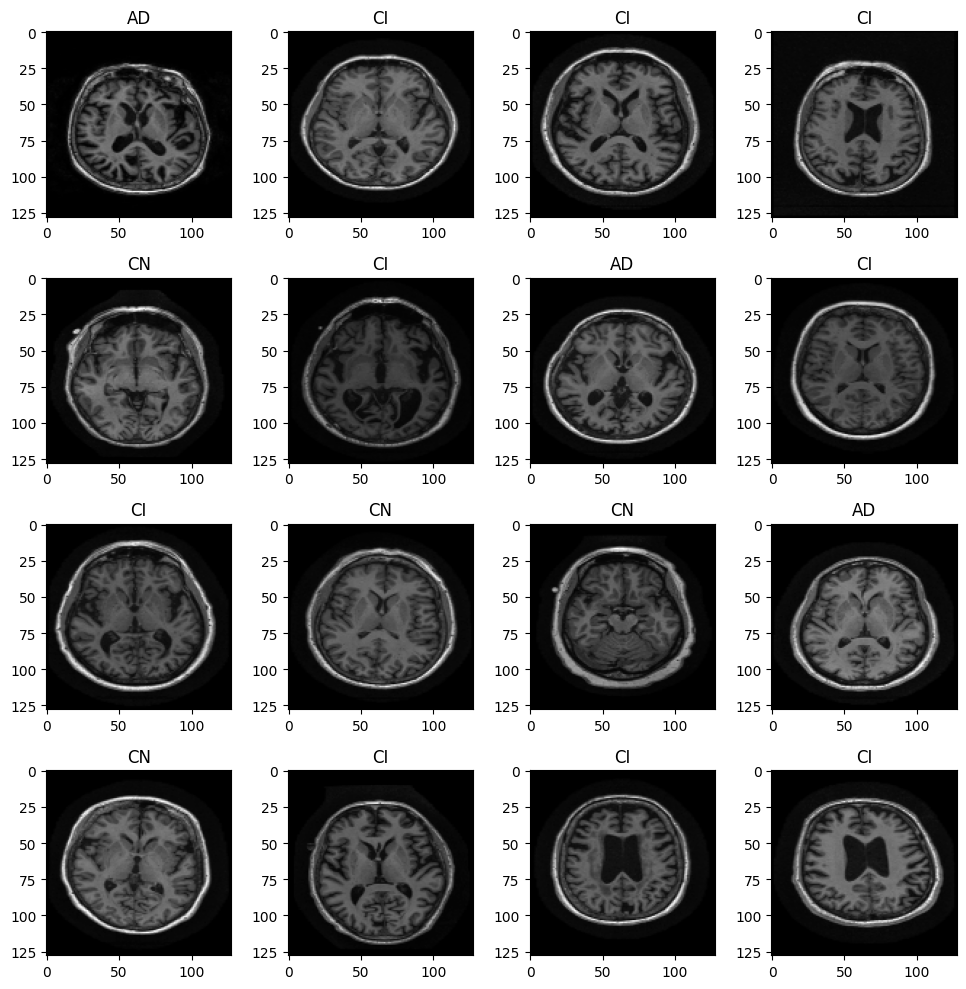

In [7]:
plt.figure(figsize = (10, 10))

for i in range(16):
    img = X[i]
    plt.subplot(4, 4, i + 1)
    plt.title(label_map[y[i]])
    plt.gray()
    plt.imshow(img)
    plt.tight_layout()
plt.show()

AD


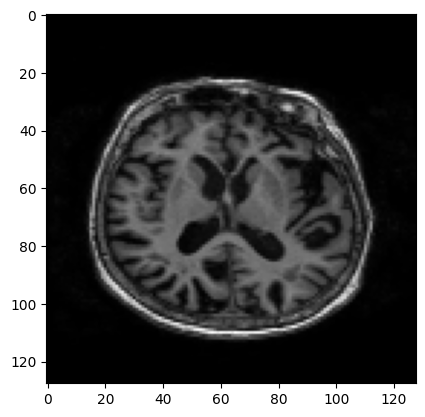

CI


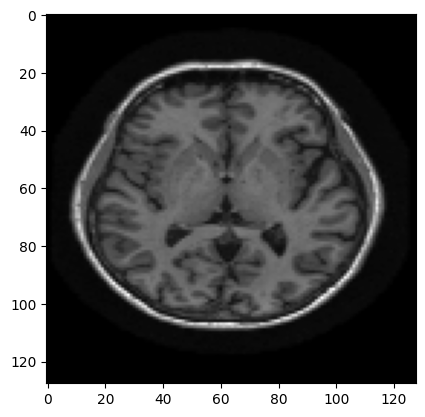

CN


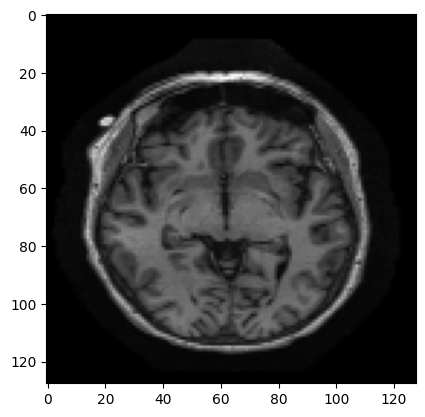

In [8]:
visited = set()

for img, label in zip(X_gray, y):
    if len(visited) == 3:
        break
    if label in visited:
        continue
    visited.add(label)
    print(label_map[label])
    plt.gray()
    plt.imshow(img)
    plt.show()

In [9]:
label_counts = pd.Series(y).value_counts()
print(label_counts)

1    2590
2    1440
0    1124
Name: count, dtype: int64


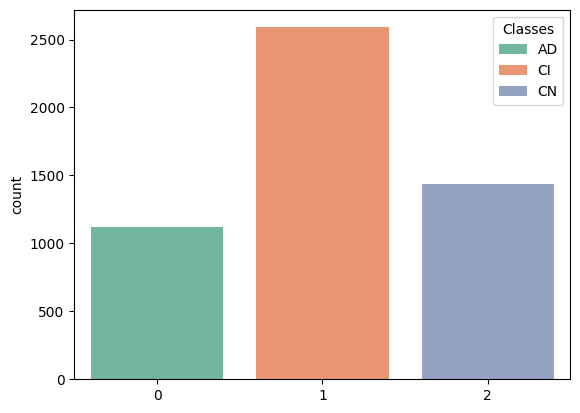

In [10]:

sns.countplot(x = y, palette='Set2')
plt.legend(title="Classes", labels=label_map.values())
plt.show()

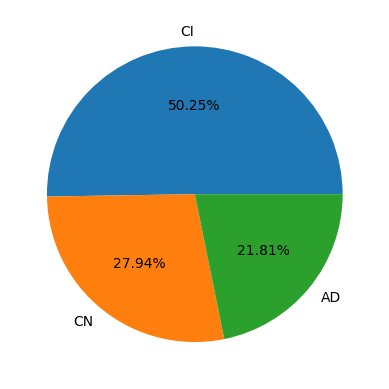

In [11]:
plt.pie(label_counts, autopct = "%.2f%%", labels = list(map(lambda key : label_map[key], label_counts.keys())))
plt.show()

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal_and_vertical"),
])

In [13]:
X_new, y_new = [], []
max_total = 3000
X_0, X_1, X_2 = X[y == 0], X[y == 1], X[y == 2]

for label, X_set in zip(label_map.keys(), [X_0, X_1, X_2]):
    count = 0
    for img in X_set:
        if count > max_total - label_counts[label]:
            break
        for i in range(2):
            augmented_img = data_augmentation(img)
            X_new.append(augmented_img)
            y_new.append(label)
            count += 1

X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(3852, 128, 128, 1) (3852,)


In [14]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

(9006, 128, 128, 1) (9006,)


In [15]:
print(pd.Series(y).value_counts())

0    3002
1    3002
2    3002
Name: count, dtype: int64


In [16]:
# Min-Max Normalization

X = X / 255.0
print(X.min(), X.max())

0.0 0.9921568627450981


In [17]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.15,
                                                                            random_state = 3, stratify = y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.15,
                                                                  random_state = 3, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

print(f"Total instances: {X.shape[0]}\nTrain instances: {X_train.shape[0]}   \
        \nValidation instances: {X_val.shape[0]}\nTest instances: {X_test.shape[0]}")

(6506, 128, 128, 1) (1149, 128, 128, 1) (1351, 128, 128, 1)
Total instances: 9006
Train instances: 6506           
Validation instances: 1149
Test instances: 1351


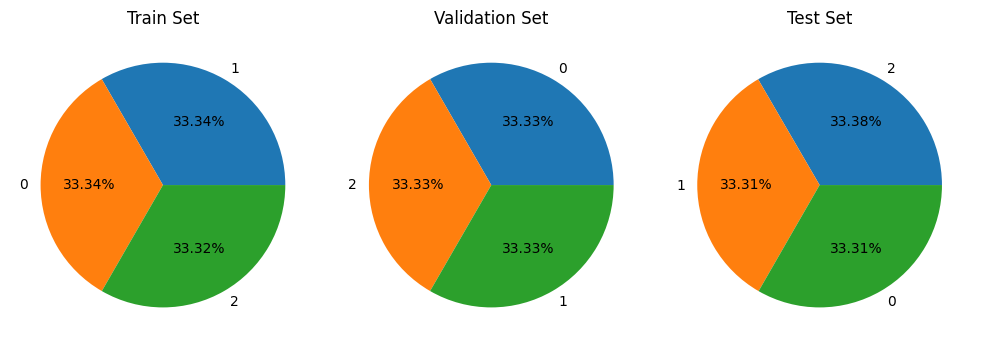

In [18]:
# Checking whether the classes are distributed uniformely among train, test and validation sets
plt.figure(figsize = (10, 10))

for i, labels, label_name in zip(range(3), [y_train, y_val, y_test], ["Train Set", "Validation Set", "Test Set"]):
    plt.subplot(3, 3, i + 1)
    plt.title(label_name)
    label_counts = pd.Series(labels).value_counts()
    plt.pie(label_counts, autopct = "%.2f%%", labels = label_counts.keys())
    plt.tight_layout()
plt.show()

In [20]:
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Modèle building avec Dropout
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=200, kernel_size=(3, 3), input_shape=X_train.shape[1:], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.1),  # Dropout réduit après la première couche Conv2D

    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    Dropout(0.1),  # Dropout réduit après la deuxième couche Conv2D

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=100, activation="relu"),
    Dropout(0.2),  # Dropout réduit après la couche Dense

    tf.keras.layers.Dense(units=50, activation="relu"),
    Dropout(0.2),  # Dropout réduit après cette couche Dense

    tf.keras.layers.Dense(units=3, activation="softmax")
])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 200)       │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 42, 42, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 42, 42, 200)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 100)         │         180,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 13, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16900)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       1,690,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,877,403 (7.16 MB)

 Trainable params: 1,877,403 (7.16 MB)

 Non-trainable params: 0 (0.00 B)

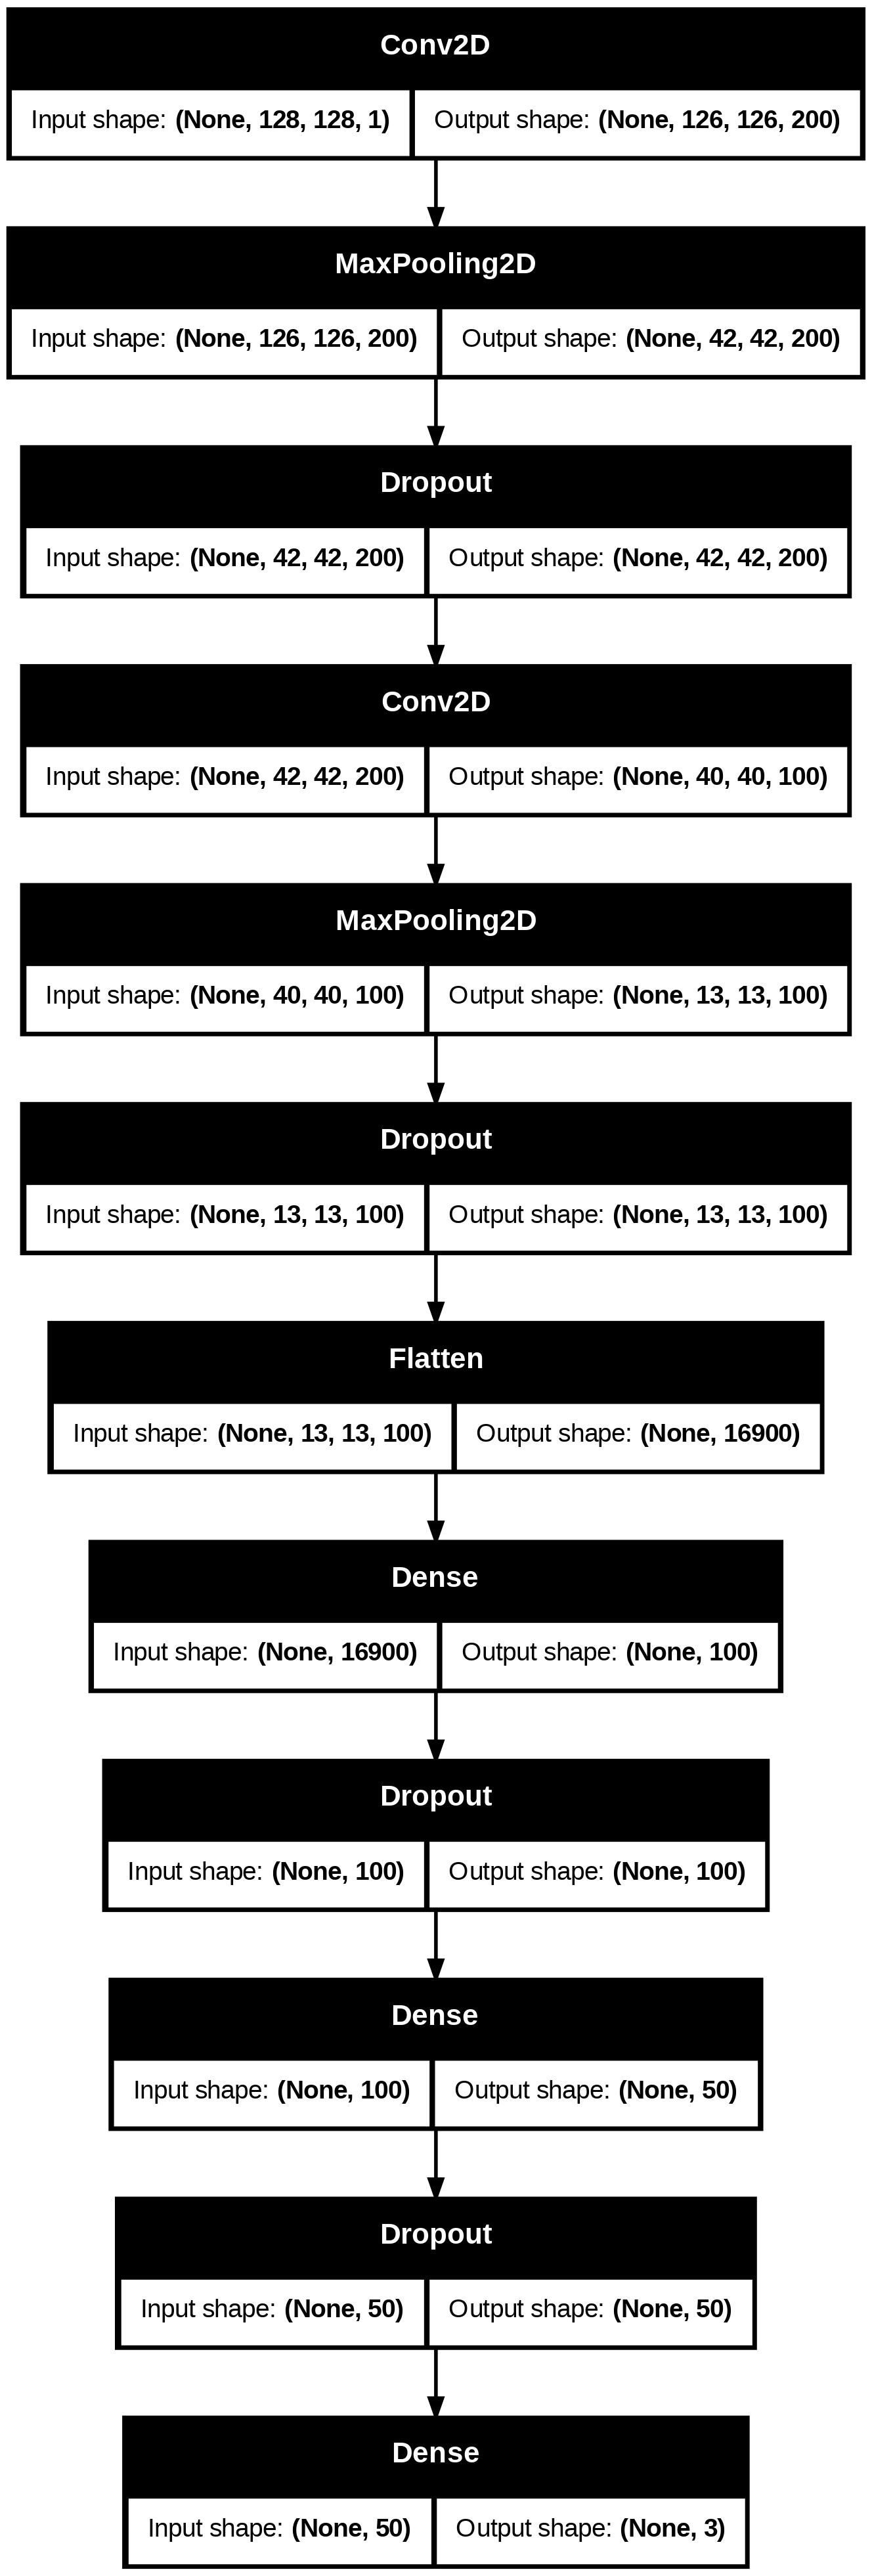

In [22]:
model_arch = tf.keras.utils.plot_model(model, show_shapes = True)
model_arch

In [23]:
# Model compilation

model.compile(optimizer = "adam", loss = "SparseCategoricalCrossentropy", metrics = ["accuracy"])

In [24]:
cb1 = tf.keras.callbacks.ModelCheckpoint("clf_model.keras", save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 3, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, callbacks = [cb1, cb2], validation_data = (X_val, y_val))

Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.3810 - loss: 1.0853 - val_accuracy: 0.5883 - val_loss: 0.8796
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.6114 - loss: 0.8336 - val_accuracy: 0.7520 - val_loss: 0.6250
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7856 - loss: 0.5256 - val_accuracy: 0.8460 - val_loss: 0.3955
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8508 - loss: 0.3729 - val_accuracy: 0.9086 - val_loss: 0.2441
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8960 - loss: 0.2649 - val_accuracy: 0.9399 - val_loss: 0.1706
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.9140 - loss: 0.2222 - val_accuracy: 0.9513 - val_loss: 0.1391
Epoch 7/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9282 - loss: 0.1797 - val_accuracy: 0.9591 - val_loss: 0.1198
Epoch 8/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9450 - loss: 0.14

In [25]:
result_df = pd.DataFrame(history.history)
result_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.430372,1.045822,0.588338,0.879562
1,0.665693,0.742644,0.751958,0.625021
2,0.804334,0.482020,0.845953,0.395524
3,0.863818,0.343547,0.908616,0.244107
4,0.898401,0.261869,0.939948,0.170625


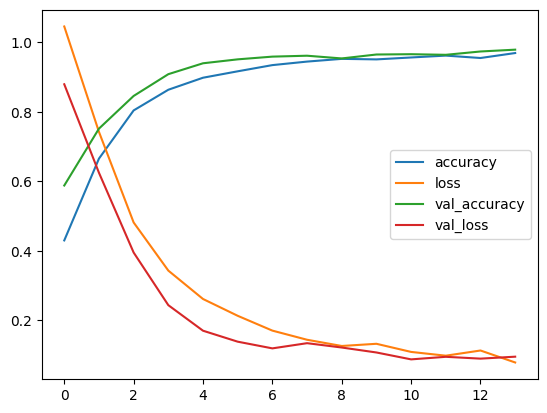

In [26]:
# Learning curves

result_df.plot()
plt.show()

In [27]:
# Evaluating the model on train set

loss, acc = model.evaluate(X_train, y_train)

204/204 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9865 - loss: 0.0346


In [28]:
# Confusion Matrix

y_train_pred = model.predict(X_train)
y_train_pred_labels = np.array([np.argmax(y_) for y_ in y_train_pred])

cm = tf.math.confusion_matrix(labels = y_train, predictions = y_train_pred_labels)
print(cm)

204/204 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
tf.Tensor(
[[2158    6    5]
 [   5 2106   58]
 [   6    5 2157]], shape=(3, 3), dtype=int32)


In [29]:
# Evaluating the model on test set

loss, acc = model.evaluate(X_test, y_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9749 - loss: 0.1101


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


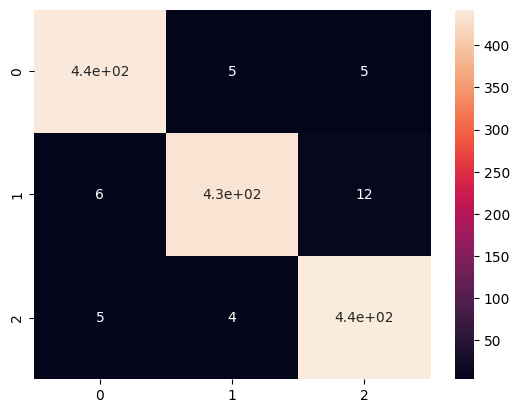

In [30]:
# Confusion Matrix

y_test_pred = model.predict(X_test)
y_test_pred_labels = np.array([np.argmax(y_) for y_ in y_test_pred])

cm = tf.math.confusion_matrix(labels = y_test, predictions = y_test_pred_labels)

sns.heatmap(cm, annot = True)
plt.show()

In [31]:
tp_0, tn_0 = cm[0][0], cm[1][1] + cm[1][2] + cm[2][1] + cm[2][2]
fp_0, fn_0 = cm[1][0] + cm[2][0], cm[0][1] + cm[0][2]

tp_1, tn_1 = cm[1][1], cm[0][0] + cm[0][2] + cm[2][0] + cm[2][2]
fp_1, fn_1 = cm[0][1] + cm[2][1], cm[1][0] + cm[1][2]

tp_2, tn_2 = cm[2][2], cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]
fp_2, fn_2 = cm[0][2] + cm[1][2], cm[2][0] + cm[2][1]

def describeCM(tp, tn, fp, fn, i):
    print(f"\n\nClass {label_map[i]} : \n")
    print(f"True Positives : {tp}\nTrue Negatives : {tn}\nFalse Positives : {fp}\nFalse Negatives : {fn}")
    precision, recall = tp / (tp + fp), tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f"\nPrecision : {precision}\nRecall (Sensitivity) : {recall}\nF1-Score : {f1}")

describeCM(tp_0, tn_0, fp_0, fn_0, 0)
describeCM(tp_1, tn_1, fp_1, fn_1, 1)
describeCM(tp_2, tn_2, fp_2, fn_2, 2)



Class AD : 

True Positives : 440
True Negatives : 890
False Positives : 11
False Negatives : 10

Precision : 0.975609756097561
Recall (Sensitivity) : 0.9777777777777777
F1-Score : 0.97669256381798


Class CI : 

True Positives : 432
True Negatives : 892
False Positives : 9
False Negatives : 18

Precision : 0.9795918367346939
Recall (Sensitivity) : 0.96
F1-Score : 0.9696969696969697


Class CN : 

True Positives : 442
True Negatives : 883
False Positives : 17
False Negatives : 9

Precision : 0.9629629629629629
Recall (Sensitivity) : 0.9800443458980045
F1-Score : 0.9714285714285714


In [32]:
# Classification Report

clf_report = metrics.classification_report(y_test, y_test_pred_labels)
print(clf_report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       450
           1       0.98      0.96      0.97       450
           2       0.96      0.98      0.97       451

    accuracy                           0.97      1351
   macro avg       0.97      0.97      0.97      1351
weighted avg       0.97      0.97      0.97      1351



In [33]:
model.save("clf_model_final.keras")